In [1]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [2]:
from sklearn.datasets import load_files

sa_train = load_files('/content/dataset/airlinetweets')


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/airlinetweets'

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score


In [ ]:
# Load the dataset
texts = [t.decode('utf-8') for t in sa_train.data]
labels = sa_train.target

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.2)

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class AirlineTweetsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert to Torch datasets
train_dataset = AirlineTweetsDataset(train_encodings, train_labels)
val_dataset = AirlineTweetsDataset(val_encodings, val_labels)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  # Assuming 3 classes for your task


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=10,              # Total number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,                # Log every X updates steps
    evaluation_strategy="steps",     # Evaluation is done (and logged) every X steps
    eval_steps=500,                  # Number of steps to perform evaluation
    load_best_model_at_end=True,     # Load the best model when finished training (based on metrics)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)




/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.066400,0.552060,0.871714,0.869498,0.873132,0.871714
1000,0.011400,0.650251,0.883281,0.882383,0.883428,0.883281
1500,0.001800,0.759758,0.888538,0.888056,0.888171,0.888538
2000,0.017700,0.759684,0.888538,0.887894,0.888893,0.888538


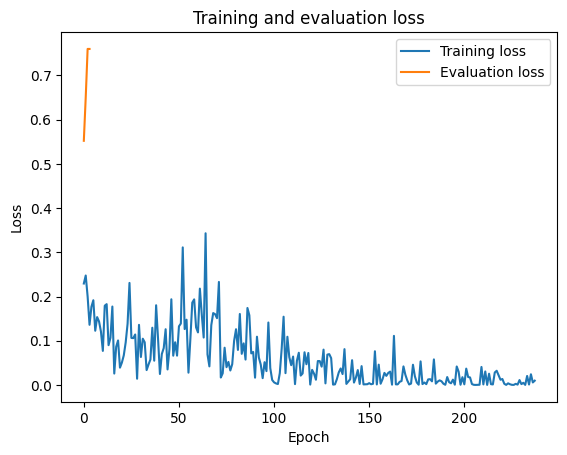

In [ ]:
# Execute training
train_result = trainer.train()

# Access the training and evaluation history
training_stats = trainer.state.log_history

train_loss = [log['loss'] for log in training_stats if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_stats if 'eval_loss' in log]

import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

st_test = pd.read_csv('sentiment-topic-test.tsv', delimiter='\t').drop(columns=['sentence id'])
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

#Tokenize the test data properly
test_encodings = tokenizer(list(st_test.text.values), truncation=True, padding=True, max_length=128)

#Create a test dataset from test_encodings
test_dataset = TestDataset(test_encodings)

# Perform predictions using the Trainer object
predictions = trainer.predict(test_dataset)

# Process predictions to extract label indices and convert to label names if needed
predicted_labels = np.argmax(predictions.predictions, axis=1)



In [ ]:

id_to_label = {0: 'positive', 1: 'neutral', 2: 'negative'}

# Convert numeric predictions to string labels
predicted_labels_str = [id_to_label[id] for id in predicted_labels]

true_labels = st_test['sentiment'].values

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels_str, target_names=['positive', 'neutral', 'negative'])

# Display the classification report
print(report)



              precision    recall  f1-score   support

    positive       0.50      0.50      0.50         4
     neutral       1.00      0.33      0.50         3
    negative       0.20      0.33      0.25         3

    accuracy                           0.40        10
   macro avg       0.57      0.39      0.42        10
weighted avg       0.56      0.40      0.42        10



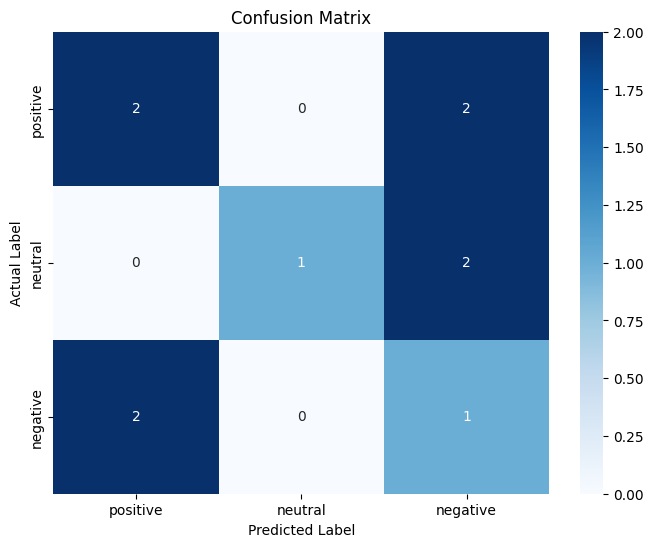

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_str)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
